In [1]:
%matplotlib notebook

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import os.path as osp
import yaml
import seml
from model.gnn import make_model_by_configuration
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification
from data.gust_dataset import GustDataset
from data.util import data_get_num_attributes, data_get_num_classes, stratified_split_with_fixed_test_set_portion, SplitDataset
from torch_geometric.data import Data
from tqdm import tqdm
from collections import defaultdict

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    checkpoint_location = 'cuda'
else:
    device = torch.device('cpu')
    checkpoint_location = 'cpu'

In [6]:
collection_name = 'week2_single_model'
collection = seml.database.get_collection(collection_name)
results = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] == 'COMPLETED']

In [19]:
# Load a model
def load_model_and_data(result, collection_name, split_idx=0, initialization=0, load_model_checkpoint=True, checkpoint_location='gpu'):
    data = GustDataset(result['config']['data']['dataset'])
    mask, _ = stratified_split_with_fixed_test_set_portion(data[0].y.numpy(),  result['config']['data']['num_dataset_splits'],
                                                           portion_train=result['config']['data']['train_portion'], 
                                                           portion_val=result['config']['data']['val_portion'], 
                                                           portion_test_fixed=result['config']['data']['test_portion_fixed'], 
                                                           portion_test_not_fixed=result['config']['data']['test_portion'],
                                                           )
    data_train = SplitDataset(data, mask[0, split_idx])
    data_val = SplitDataset(data, mask[1, split_idx])
    input_dim = data_get_num_attributes(data[0])
    output_dim = data_get_num_classes(data[0])
    backbone = make_model_by_configuration(result['config']['model'], input_dim, output_dim)
    model = SemiSupervisedNodeClassification(backbone, learning_rate=result['config']['training']['learning_rate'])
    if load_model_checkpoint:
        checkpoint_dir = osp.join('/nfs/students/fuchsgru/artifacts', str(collection_name), str(result['id']), f'{split_idx}-{initialization}')
        checkpoint_files = [fname for fname in os.listdir(checkpoint_dir) if fname.endswith('.ckpt')]
        if len(checkpoint_files) > 0:
            print(f'Multiple checkpoints to choose from, use {checkpoint_files[0]}')
        checkpoint_file = osp.join(checkpoint_dir, checkpoint_files[0])
        checkpoint = torch.load(checkpoint_file, map_location=torch.device(checkpoint_location))
        model.load_state_dict(checkpoint['state_dict'])
    
    model.eval()
            
    return model, data_train, data_val

In [20]:
@torch.no_grad()
def logit_space_bounds(model, data_val):
    logits = model(data_val[0])[-1][data_val[0].mask]
    return logits.min(dim=0)[0], logits.max(dim=0)[0]
    

In [21]:
@torch.no_grad()
def local_perturbations(model, data_val, perturbations=np.linspace(0.1, 5.0, 50), num_perturbations_per_sample=10):
    logits = model(data_val[0])[-1]
    result = {}
    for eps in tqdm(perturbations):
        results_eps = []
        for _ in range(num_perturbations_per_sample):
            noise = torch.randn(list(data_val[0].x.size()))
            noise = noise / noise.norm(dim=-1, keepdim=True) * eps
            x_perturbed = data_val[0].x + noise
            data = Data(x=x_perturbed, edge_index=data_val[0].edge_index)
            logits_perturbed = model(data)[-1]
            results_eps.append((logits - logits_perturbed).norm(dim=1))
            
        result[eps] = torch.cat(results_eps)
    return result

In [22]:
def local_perturbations_plot(perturbations, config=None):
    xs, ys, ylower, yupper = [], [], [], []
    for eps, perturbs in perturbations.items():
        xs.append(eps)
        ys.append(perturbs.median().item())
        ylower.append(perturbs.min().item())
        yupper.append(perturbs.max().item())
        
    xs, ys, ylower, yupper = np.array(xs), np.array(ys), np.array(ylower), np.array(yupper)
    slope_ys = (ys / xs).mean()
    slope_yupper = (yupper / xs).max()
    
    fig, axs = plt.subplots(1, 1)
    axs.plot(np.array(xs), np.array(ys))
    axs.fill_between(np.array(xs), np.array(ylower), np.array(yupper), alpha=0.1)
    axs.plot(np.array([xs.min(), xs.max()]), slope_ys * np.array([xs.min(), xs.max()]), '--', 
             color='red', alpha=0.5, label=f'Average Median local perturbation (Slope={slope_ys:.2f})')
    axs.plot(np.array([xs.min(), xs.max()]), slope_yupper * np.array([xs.min(), xs.max()]), '--', 
             color='orange', alpha=0.5, label=f'Bound on local perturbation (Slope={slope_yupper:.2f})')
    
    axs.legend()
    axs.set_xlabel('Input perturbation')
    axs.set_ylabel('Output perturbation')
    
    return fig, axs, slope_ys, slope_yupper

In [23]:
# Reorder results to access them like [model][data][spectral_norm]
runs = defaultdict(lambda: defaultdict(dict))
for result in results:
    config = result['config']
    runs[config['model']['model_type']][config['data']['dataset']][config['model']['use_spectral_norm']] = result

In [24]:
%ls evaluation/week2/local_lipschitz_plots

appnp-False-32-citeseer.pdf    gcn-True-64-citeseer.pdf
appnp-False-64-64-cora_ml.pdf  gcn-True-64-cora_ml.pdf
appnp-True-32-citeseer.pdf     gin-False-64-citeseer.pdf
appnp-True-64-64-cora_ml.pdf   gin-False-64-cora_ml.pdf
gat-False-64-64-citeseer.pdf   gin-True-64-citeseer.pdf
gat-False-64-64-cora_ml.pdf    gin-True-64-cora_ml.pdf
gat-True-64-64-citeseer.pdf    mlp-False-32-cora_ml.pdf
gat-True-64-64-cora_ml.pdf     mlp-False-64-citeseer.pdf
gat-True-64-64-pubmed.pdf      mlp-True-32-cora_ml.pdf
gcn-False-64-citeseer.pdf      mlp-True-64-citeseer.pdf
gcn-False-64-cora_ml.pdf


Skipping figure evaluation/week2/local_lipschitz_plots/gat-True-64-64-cora_ml.pdf because it exists.
Skipping figure evaluation/week2/local_lipschitz_plots/gat-False-64-64-cora_ml.pdf because it exists.
Skipping figure evaluation/week2/local_lipschitz_plots/gcn-True-64-cora_ml.pdf because it exists.
Skipping figure evaluation/week2/local_lipschitz_plots/gcn-False-64-cora_ml.pdf because it exists.
Skipping figure evaluation/week2/local_lipschitz_plots/gin-True-64-cora_ml.pdf because it exists.
Skipping figure evaluation/week2/local_lipschitz_plots/gin-False-64-cora_ml.pdf because it exists.
Skipping figure evaluation/week2/local_lipschitz_plots/mlp-True-32-cora_ml.pdf because it exists.
Skipping figure evaluation/week2/local_lipschitz_plots/mlp-False-32-cora_ml.pdf because it exists.
Skipping figure evaluation/week2/local_lipschitz_plots/appnp-True-64-64-cora_ml.pdf because it exists.
Skipping figure evaluation/week2/local_lipschitz_plots/appnp-False-64-64-cora_ml.pdf because it exists.

100%|██████████| 50/50 [28:36<00:00, 34.32s/it]


<IPython.core.display.Javascript object>


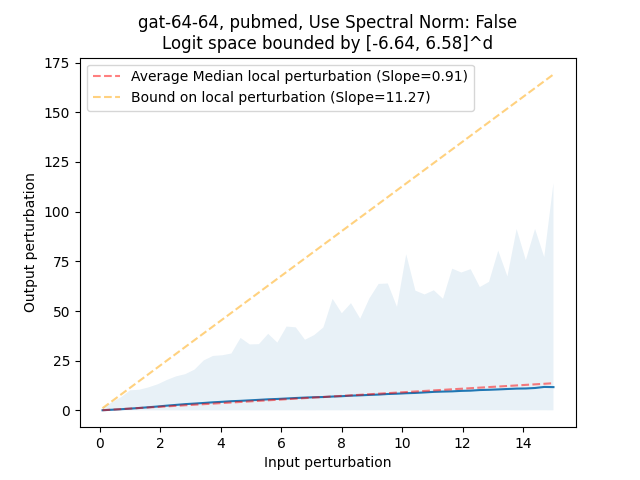

Multiple checkpoints to choose from, use epoch=164-step=164.ckpt


100%|██████████| 50/50 [02:51<00:00,  3.43s/it]


<IPython.core.display.Javascript object>


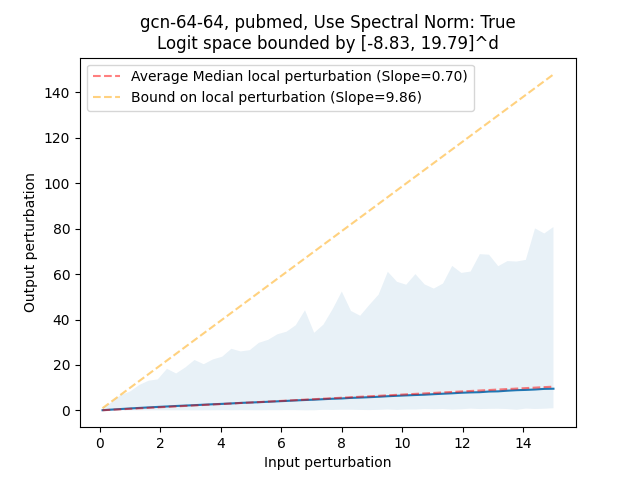

Multiple checkpoints to choose from, use epoch=49-step=49.ckpt


100%|██████████| 50/50 [02:51<00:00,  3.42s/it]


<IPython.core.display.Javascript object>


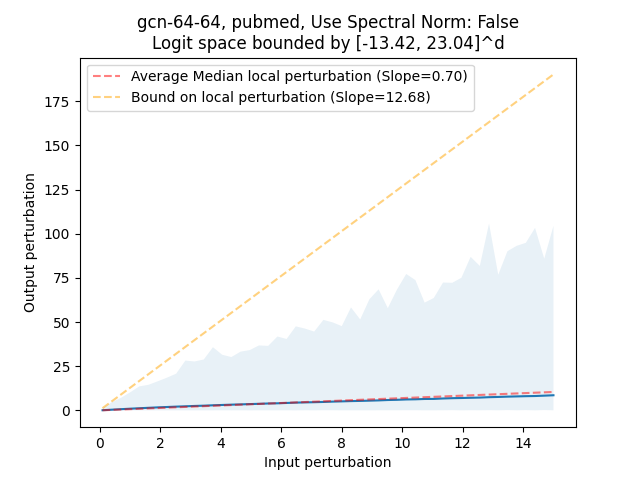

Multiple checkpoints to choose from, use epoch=60-step=60.ckpt


100%|██████████| 50/50 [07:00<00:00,  8.41s/it]


<IPython.core.display.Javascript object>


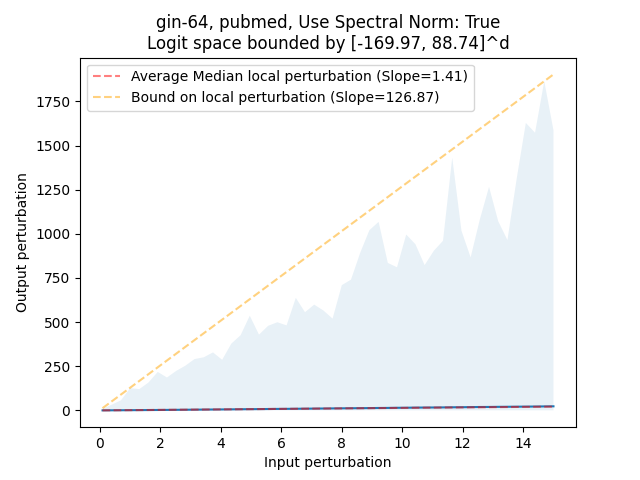

Multiple checkpoints to choose from, use epoch=15-step=15.ckpt


100%|██████████| 50/50 [07:00<00:00,  8.41s/it]


<IPython.core.display.Javascript object>


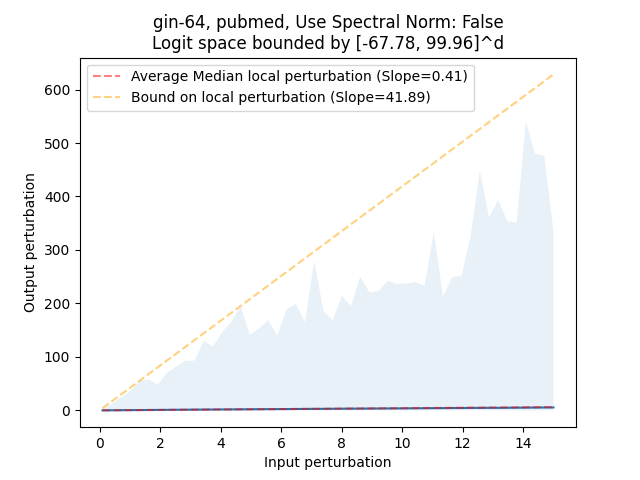

Multiple checkpoints to choose from, use epoch=65-step=65.ckpt


100%|██████████| 50/50 [01:25<00:00,  1.72s/it]


<IPython.core.display.Javascript object>


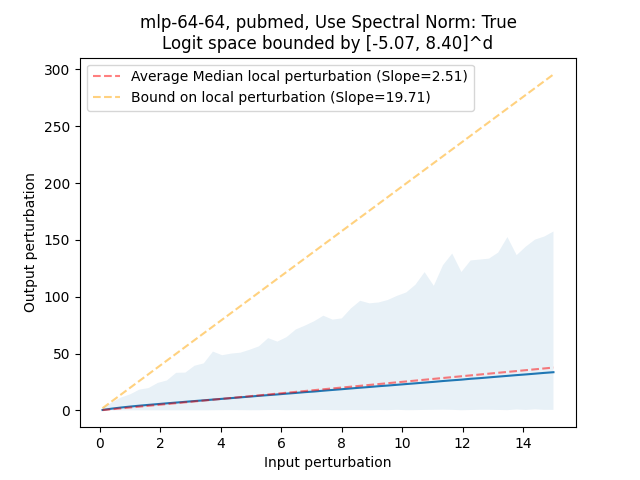

Multiple checkpoints to choose from, use epoch=44-step=44.ckpt


100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


<IPython.core.display.Javascript object>


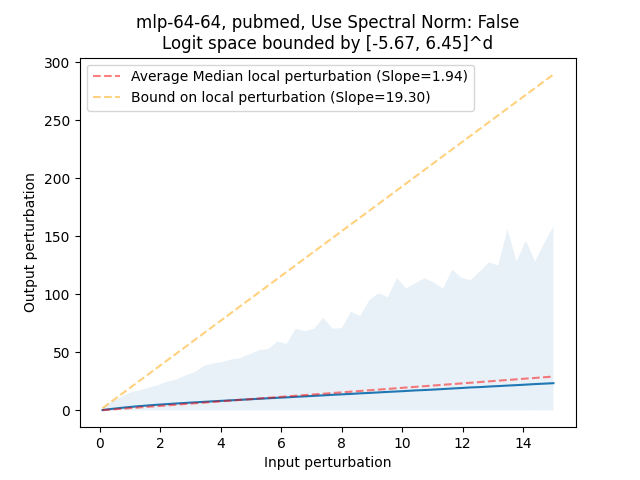

Multiple checkpoints to choose from, use epoch=147-step=147.ckpt


100%|██████████| 50/50 [01:28<00:00,  1.76s/it]


<IPython.core.display.Javascript object>


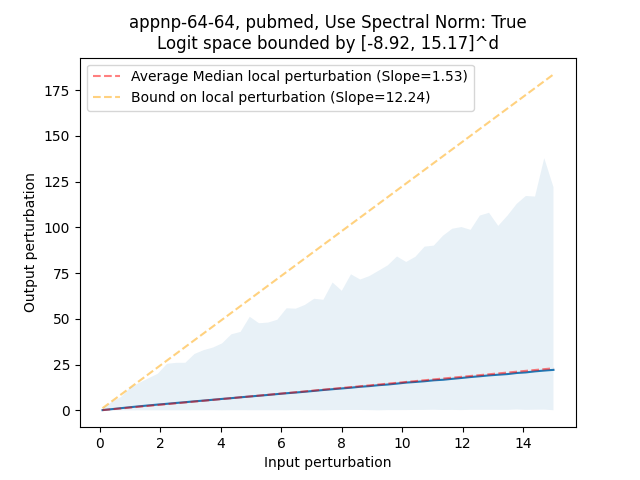

Multiple checkpoints to choose from, use epoch=54-step=54.ckpt


100%|██████████| 50/50 [01:27<00:00,  1.76s/it]


<IPython.core.display.Javascript object>


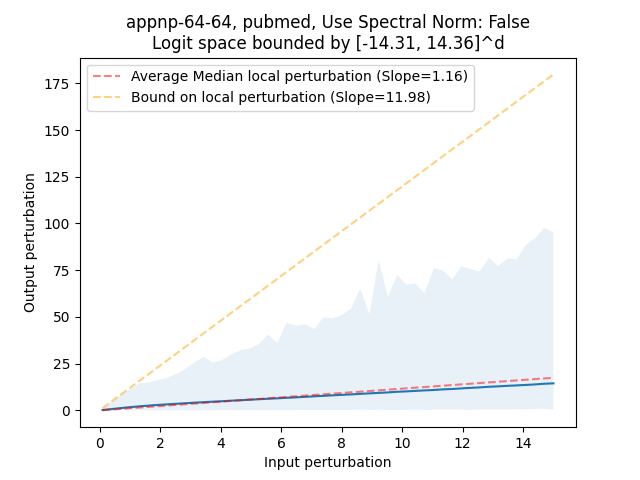

Multiple checkpoints to choose from, use epoch=67-step=67.ckpt


100%|██████████| 50/50 [06:34<00:00,  7.89s/it]


<IPython.core.display.Javascript object>


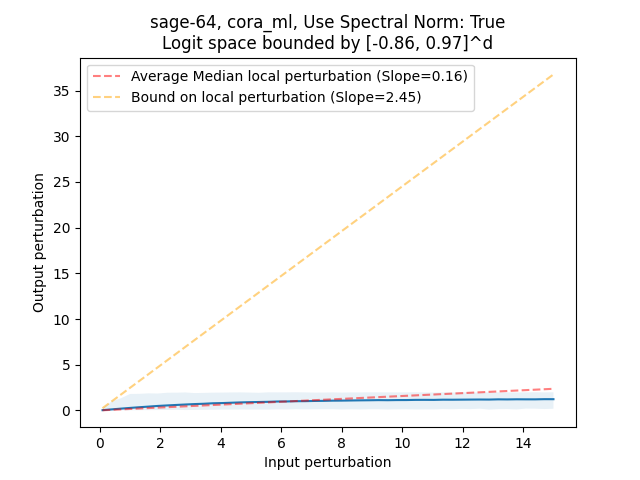

Multiple checkpoints to choose from, use epoch=36-step=36.ckpt


100%|██████████| 50/50 [06:37<00:00,  7.94s/it]


<IPython.core.display.Javascript object>


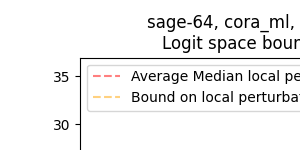

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/gust-0.1-py3.9.egg/gust/preprocessing.py:238: UserWarning: 124 self loops removed
  warnings.warn("{0} self loops removed".format(num_self_loops))


Multiple checkpoints to choose from, use epoch=20-step=20.ckpt


100%|██████████| 50/50 [04:32<00:00,  5.44s/it]


<IPython.core.display.Javascript object>


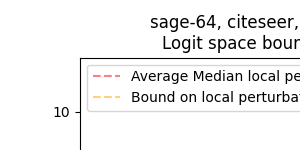

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/gust-0.1-py3.9.egg/gust/preprocessing.py:238: UserWarning: 124 self loops removed
  warnings.warn("{0} self loops removed".format(num_self_loops))


Multiple checkpoints to choose from, use epoch=18-step=18.ckpt


100%|██████████| 50/50 [04:32<00:00,  5.44s/it]


<IPython.core.display.Javascript object>


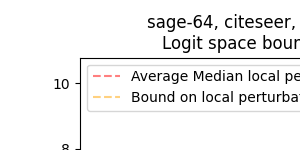

Multiple checkpoints to choose from, use epoch=31-step=31.ckpt


100%|██████████| 50/50 [06:59<00:00,  8.38s/it]


<IPython.core.display.Javascript object>


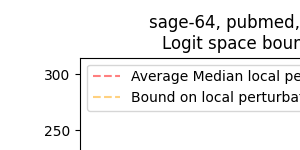

Multiple checkpoints to choose from, use epoch=19-step=19.ckpt


100%|██████████| 50/50 [07:03<00:00,  8.47s/it]


<IPython.core.display.Javascript object>


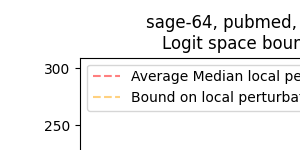

In [25]:
def pipeline(result, collection_name, num_perturbations_per_sample=10, 
             output_dir='evaluation/week2/local_lipschitz_plots',
             checkpoint_location='gpu',):
    config = result['config']
    model_type = config['model']['model_type']
    hidden_sizes = '-'.join(map(str, config['model']['hidden_sizes']))
    dataset_name = config['data']['dataset']
    use_spectral_norm = config['model']['use_spectral_norm']
    figure_path = osp.join(output_dir, f'{model_type}-{use_spectral_norm}-{hidden_sizes}-{dataset_name}.pdf')
    if osp.exists(figure_path):
        print(f'Skipping figure {figure_path} because it exists.')
        return
    
    model, data_train, data_val = load_model_and_data(result, collection_name, checkpoint_location=checkpoint_location)
    logits_min, logits_max = logit_space_bounds(model, data_val)
    random_perturbations = local_perturbations(model, data_val, perturbations=np.linspace(0.1, 15.0, 50), num_perturbations_per_sample=num_perturbations_per_sample)
    fig, axs, slope_ys, slope_yupper = local_perturbations_plot(random_perturbations, config=result['config'])
    intervals = [f'[{l:.2f}, {u:.2f}]' for l, u in zip(logits_min.numpy(), logits_max.numpy())]
    #print(f'Intervals of logit space on validation data: {",".join(intervals)}')
    
    
    title = f'{model_type}-{hidden_sizes}, {dataset_name}, Use Spectral Norm: {use_spectral_norm}\nLogit space bounded by [{logits_min.min().item():.2f}, {logits_max.max().item():.2f}]^d'

    axs.set_title(title)
    plt.savefig(figure_path)
    
for result in results:
    pipeline(result, collection_name, output_dir='evaluation/week2/local_lipschitz_plots', checkpoint_location=checkpoint_location)
    #pipeline(runs['gcn']['cora_ml'][False], collection_name)

In [26]:
local_perturbations_plot

<function __main__.local_perturbations_plot(perturbations, config=None)>